In [ ]:
import torch
from torch.utils.data import DataLoader
import torch
import plotly
import plotly.express as px
import plotly.graph_objs as graph_obj
import matplotlib
from matplotlib import pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import os

np.random.seed(42)

from collections import namedtuple
from rich.table import Table

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.__version__, torchvision.__version__, torchaudio.__version__,

('2.6.0+cu124', '0.21.0+cu124', '2.6.0+cu124')

Building Blocks with PyTorch

<Axes: xlabel='date'>

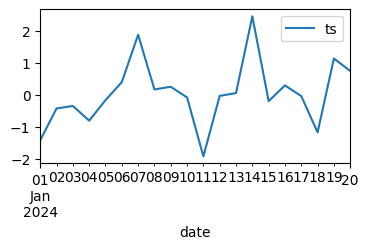

In [ ]:
''' generate a random time series '''
df = pd.DataFrame({'date': pd.date_range(periods=20, start='2024-01-01', freq='D'),
    'ts': np.random.randn(20) })
df.plot(x='date', y='ts', figsize=(4, 2))

In [ ]:
ts = torch.from_numpy(df.ts.values).float()
ts,

(tensor([-0.4792, -0.1857, -1.1063, -1.1962,  0.8125,  1.3562, -0.0720,  1.0035,
          0.3616, -0.6451,  0.3614,  1.5380, -0.0358,  1.5646, -2.6197,  0.8219,
          0.0870, -0.2990,  0.0918, -1.9876]),)

In [ ]:
''' create windows over dataset for batch training'''
window_size = 15
ts_ds = ts.unfold(dimension=0, size=window_size, step=1)
ts_ds[:], ts_ds.shape

(tensor([[-0.4792, -0.1857, -1.1063, -1.1962,  0.8125,  1.3562, -0.0720,  1.0035,
           0.3616, -0.6451,  0.3614,  1.5380, -0.0358,  1.5646, -2.6197],
         [-0.1857, -1.1063, -1.1962,  0.8125,  1.3562, -0.0720,  1.0035,  0.3616,
          -0.6451,  0.3614,  1.5380, -0.0358,  1.5646, -2.6197,  0.8219],
         [-1.1063, -1.1962,  0.8125,  1.3562, -0.0720,  1.0035,  0.3616, -0.6451,
           0.3614,  1.5380, -0.0358,  1.5646, -2.6197,  0.8219,  0.0870],
         [-1.1962,  0.8125,  1.3562, -0.0720,  1.0035,  0.3616, -0.6451,  0.3614,
           1.5380, -0.0358,  1.5646, -2.6197,  0.8219,  0.0870, -0.2990],
         [ 0.8125,  1.3562, -0.0720,  1.0035,  0.3616, -0.6451,  0.3614,  1.5380,
          -0.0358,  1.5646, -2.6197,  0.8219,  0.0870, -0.2990,  0.0918],
         [ 1.3562, -0.0720,  1.0035,  0.3616, -0.6451,  0.3614,  1.5380, -0.0358,
           1.5646, -2.6197,  0.8219,  0.0870, -0.2990,  0.0918, -1.9876]]),
 torch.Size([6, 15]))

In [ ]:
''' feed forward network architecture
window[window-input] >> 64 (hidden layer 1) >> 32 (hidden layer 2) >> 1 (output) '''
FFNetwork = nn.Sequential(
    nn.Linear(in_features=window_size, out_features=64), # batch-size * window
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1)
)
ts_ds.shape, FFNetwork(ts_ds).shape,  FFNetwork.forward(ts_ds),

(torch.Size([6, 15]),
 torch.Size([6, 1]),
 tensor([[0.1030],
         [0.0950],
         [0.0646],
         [0.0876],
         [0.1093],
         [0.1590]], grad_fn=<AddmmBackward0>))

In [ ]:
table = Table(title='FFNetwork Architecture', show_lines=False)
table.add_column('Layer', justify='center')
#table.add_column('Input', justify='left')
#table.add_column('Output', justify='left')
table.add_column('Shape')
x = ts_ds
table.add_row('Input', str(x.shape))
for layer in FFNetwork:
    x = layer(x)
    table.add_row(str(layer), str(x.shape))
table

                           FFNetwork Architecture                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃                       Layer                        ┃ Shape               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│                       Input                        │ torch.Size([6, 15]) │
│ Linear(in_features=15, out_features=64, bias=True) │ torch.Size([6, 64]) │
│                       ReLU()                       │ torch.Size([6, 64]) │
│ Linear(in_features=64, out_features=32, bias=True) │ torch.Size([6, 32]) │
│                       ReLU()                       │ torch.Size([6, 32]) │
│ Linear(in_features=32, out_features=32, bias=True) │ torch.Size([6, 32]) │
│                       ReLU()                       │ torch.Size([6, 32]) │
│ Linear(in_features=32, out_features=1, bias=True)  │ torch.Size([6, 1])  │
└────────────────────────────────────────────────────┴─────────────────────┘

In [ ]:
''' RNN with a 3-d tensor '''
rnn_input = ts_ds.unsqueeze(-1)
rnn = nn.RNN(input_size =1, hidden_size=32, num_layers=1,
             batch_first=True, dropout =0, bidirectional=False)
rnn_output, rnn_hidden_states = rnn(rnn_input)
rnn_input.shape, rnn_output.shape, rnn_hidden_states.shape

(torch.Size([6, 15, 1]), torch.Size([6, 15, 32]), torch.Size([1, 6, 32]))

In [ ]:
torch.equal(rnn_hidden_states[0], rnn_output[:,-1])

True

In [ ]:
rnn_hidden_states[0,0], rnn_output[0, -1]

(tensor([-0.1335,  0.2728, -0.1351, -0.5358, -0.2039,  0.2231, -0.2882, -0.2034,
         -0.3253, -0.3942,  0.0744,  0.2331, -0.4755, -0.2925,  0.0512,  0.0801,
         -0.0150, -0.1077,  0.1538, -0.1572, -0.2553, -0.2470, -0.0319, -0.2209,
         -0.3211, -0.1371,  0.1243, -0.1181, -0.1812, -0.2835,  0.3579, -0.4368],
        grad_fn=<SelectBackward0>),
 tensor([-0.1335,  0.2728, -0.1351, -0.5358, -0.2039,  0.2231, -0.2882, -0.2034,
         -0.3253, -0.3942,  0.0744,  0.2331, -0.4755, -0.2925,  0.0512,  0.0801,
         -0.0150, -0.1077,  0.1538, -0.1572, -0.2553, -0.2470, -0.0319, -0.2209,
         -0.3211, -0.1371,  0.1243, -0.1181, -0.1812, -0.2835,  0.3579, -0.4368],
        grad_fn=<SelectBackward0>))

In [ ]:
''' bi-directional stacked RNN '''
bi_rnn = nn.RNN(input_size =1, hidden_size=32, num_layers=5,
                batch_first=True, dropout =0, bidirectional=True)
bi_rnn_output, bi_rnn_hidden_states = bi_rnn(rnn_input)
bi_rnn_output.shape, bi_rnn_hidden_states.shape

(torch.Size([6, 15, 64]), torch.Size([10, 6, 32]))

In [ ]:
''' LSTM '''
lstm = nn.LSTM(input_size =1, hidden_size=32, num_layers=5, batch_first=True,
    dropout =0, bidirectional=False)
lstm_output, lstm_hidden_states = lstm(rnn_input)
#lstm_output, (hidden_states, cell_states) = lstm(rnn_input)
lstm_output.shape, lstm_hidden_states[0].shape, lstm_hidden_states[1].shape

(torch.Size([6, 15, 32]), torch.Size([5, 6, 32]), torch.Size([5, 6, 32]))

In [ ]:
lstm_output[0,-1], lstm_hidden_states[0][-1, 0,: ]

(tensor([-0.0063,  0.0504,  0.0468,  0.1205,  0.1131,  0.1581, -0.0481,  0.0322,
         -0.0075, -0.0428,  0.1058, -0.0936,  0.0091, -0.0301,  0.0455,  0.0264,
          0.0255, -0.0548,  0.0048, -0.0612, -0.0247, -0.0624, -0.0262,  0.0769,
          0.0163, -0.0293,  0.0850, -0.0818, -0.1546, -0.1052, -0.1514,  0.0428],
        grad_fn=<SelectBackward0>),
 tensor([-0.0063,  0.0504,  0.0468,  0.1205,  0.1131,  0.1581, -0.0481,  0.0322,
         -0.0075, -0.0428,  0.1058, -0.0936,  0.0091, -0.0301,  0.0455,  0.0264,
          0.0255, -0.0548,  0.0048, -0.0612, -0.0247, -0.0624, -0.0262,  0.0769,
          0.0163, -0.0293,  0.0850, -0.0818, -0.1546, -0.1052, -0.1514,  0.0428],
        grad_fn=<SliceBackward0>))

In [ ]:
''' GRU '''
gru = nn.GRU(input_size =1, hidden_size=32, num_layers=5, batch_first=True, dropout =0) #bidirectional=True
gru_output, gru_hidden_states = gru(rnn_input)
gru_output.shape, gru_hidden_states.shape

(torch.Size([6, 15, 32]), torch.Size([5, 6, 32]))

In [ ]:
torch.equal(gru_hidden_states[-1], gru_output[:,-1])

True

In [ ]:
gru_output[0,-1]

tensor([-0.0385,  0.0210,  0.0090,  0.1078,  0.2333, -0.2788,  0.2588,  0.0701,
        -0.3339, -0.1666,  0.0829, -0.1145, -0.0011, -0.3281, -0.0212,  0.2290,
        -0.1761,  0.0141,  0.3155,  0.1769, -0.0570,  0.0716,  0.1074,  0.3084,
         0.2191,  0.2078, -0.1920, -0.1043,  0.1492, -0.3656,  0.0753,  0.2056],
       grad_fn=<SelectBackward0>)

In [ ]:
gru_hidden_states[-1, 0:][:2]

tensor([[-0.0385,  0.0210,  0.0090,  0.1078,  0.2333, -0.2788,  0.2588,  0.0701,
         -0.3339, -0.1666,  0.0829, -0.1145, -0.0011, -0.3281, -0.0212,  0.2290,
         -0.1761,  0.0141,  0.3155,  0.1769, -0.0570,  0.0716,  0.1074,  0.3084,
          0.2191,  0.2078, -0.1920, -0.1043,  0.1492, -0.3656,  0.0753,  0.2056],
        [-0.0391,  0.0215,  0.0088,  0.1078,  0.2338, -0.2787,  0.2592,  0.0691,
         -0.3353, -0.1662,  0.0829, -0.1134, -0.0015, -0.3278, -0.0206,  0.2288,
         -0.1752,  0.0138,  0.3160,  0.1755, -0.0566,  0.0713,  0.1079,  0.3092,
          0.2189,  0.2082, -0.1920, -0.1035,  0.1497, -0.3655,  0.0759,  0.2045]],
       grad_fn=<SliceBackward0>)

In [ ]:
''' CNN with a 3-D input (batch, channels-features, seq) '''
cnn_input = ts_ds.unsqueeze(1)
k = 3
cnn_con = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=k)
cnn_output = cnn_con(cnn_input)
assert cnn_output.size(-1)==cnn_input.size(-1)-k+1
cnn_input.shape, cnn_output.shape

(torch.Size([6, 1, 15]), torch.Size([6, 1, 13]))

In [ ]:
''' effect of stride and dilation on output '''
exp_ = namedtuple('experiment', ['k', 's', 'd'])
experiment_list = [exp_(k=3, s=1, d=1), exp_(k=5, s=1, d=2), exp_(k=3, s=2, d=1),
  exp_(k=3, s=1, d=2), exp_(k=3, s=2, d=2), exp_(k=5, s=2, d=2), ]
table = Table(title='CNN Experiment', show_lines=False)
table.add_column('Kernel Size', justify='center')
table.add_column('Stride', justify='left')
table.add_column('Dilation', justify='left')
table.add_column('Input Seq Len', justify='center')
table.add_column('Padding Required', justify='left')
table.add_column('Output', justify='left')

b, c, l = cnn_input.size()
for exp in experiment_list:
  padding = exp.d*(exp.k-1) + cnn_input.size(-1) * (exp.s -1) - (exp.s -1)
  padding_input = torch.nn.functional.pad(cnn_input, pad=(padding, 0))
  cnn_conv = nn.Conv1d(
    in_channels=1, out_channels=1, kernel_size=exp.k, stride=exp.s, dilation=exp.d)
  cnn_output = cnn_conv(padding_input)
  assert cnn_output.size(-1) == cnn_input.size(-1)
  table.add_row(str(exp.k), str(exp.s), str(exp.d), str(l), str(padding), str(cnn_output.size(-1)))
table

                                CNN Experiment                                 
┏━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Kernel Size ┃ Stride ┃ Dilation ┃ Input Seq Len ┃ Padding Required ┃ Output ┃
┡━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│      3      │ 1      │ 1        │      15       │ 2                │ 15     │
│      5      │ 1      │ 2        │      15       │ 8                │ 15     │
│      3      │ 2      │ 1        │      15       │ 16               │ 15     │
│      3      │ 1      │ 2        │      15       │ 4                │ 15     │
│      3      │ 2      │ 2        │      15       │ 18               │ 15     │
│      5      │ 2      │ 2        │      15       │ 22               │ 15     │
└─────────────┴────────┴──────────┴───────────────┴──────────────────┴────────┘

In [ ]:
''' Padding to keep the dimensions the same '''

In [ ]:
''' Convolutions with equal weights in a rolling mean '''
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
conv, \
conv.weight, conv.weight.data.shape, \
conv.bias

(Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False),
 Parameter containing:
 tensor([[[-0.1024,  0.2707,  0.3655]]], requires_grad=True),
 torch.Size([1, 1, 3]),
 None)

In [ ]:
''' assign kernel weights with uniform distribution '''
conv.weight.data = torch.tensor([1/3, 1/3, 1/3]).unsqueeze(0).unsqueeze(0)
''' creating a tensor with artificial time series '''
ser_ = torch.from_numpy(df.ts.values.astype('float32'))
out = conv(ser_.unsqueeze(0).unsqueeze(0))
out, out.shape, \
out.squeeze(), out.squeeze().shape

(tensor([[[-0.7262, -0.5219, -0.4354, -0.1865,  0.7097,  0.8216,  0.7728,
            0.1192, -0.5786, -0.6732, -0.6284,  0.8323,  0.7770,  0.8575,
            0.0248, -0.3006, -0.0202,  0.2420]]],
        grad_fn=<ConvolutionBackward0>),
 torch.Size([1, 1, 18]),
 tensor([-0.7262, -0.5219, -0.4354, -0.1865,  0.7097,  0.8216,  0.7728,  0.1192,
         -0.5786, -0.6732, -0.6284,  0.8323,  0.7770,  0.8575,  0.0248, -0.3006,
         -0.0202,  0.2420], grad_fn=<SqueezeBackward0>),
 torch.Size([18]))

In [ ]:
''' calculate the rolling mean over n - (k-1) '''
rolling_means = [ser_[i: i+3].mean() for i in range(len(ser_)-2)]
rolling_means[:3], len(rolling_means)

([tensor(-0.7262), tensor(-0.5219), tensor(-0.4354)], 18)

In [ ]:
''' concatenate all into a tensor and check equality '''
rolling_means = torch.cat([t.unsqueeze(0) for t in rolling_means])
torch.allclose(rolling_means, out)

True